## Import all the required libraries

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

import nltk
from nltk.corpus import stopwords
from nltk import *
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

## Constants Definitions

In [ ]:
embedding_dim = 32
max_sequence_length = 170
max_words = 2500
samples = 20000

# 1. Import the customer complaints dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('gdrive/My Drive/complaints_processed.csv')
df.head(20)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...
5,5,credit_reporting,payment history missing credit report made mis...
6,6,credit_reporting,va date complaint experian credit bureau invol...
7,7,credit_reporting,account reported abbreviated name full name se...
8,8,credit_reporting,account reported abbreviated name full name se...
9,9,credit_reporting,usdoexxxx account reported abbreviated name fu...


In [ ]:
# Renaming columns
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [ ]:
# Analysing dataframe attributes
print('* Size of dataframe: {}\n'.format(df.shape))
print('* Datatype of columns are:\n {}\n'.format(df.dtypes))
print('* Count of different product categories:\n {}\n'.format(df['product'].value_counts()))
print('* Number of NaNs among tweets are: {}\n'.format(df['tweet'].isnull().sum()))

* Size of dataframe: (162421, 2)

* Datatype of columns are:
 product    object
tweet      object
dtype: object

* Count of different product categories:
 product
credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: count, dtype: int64

* Number of NaNs among tweets are: 10



In [ ]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


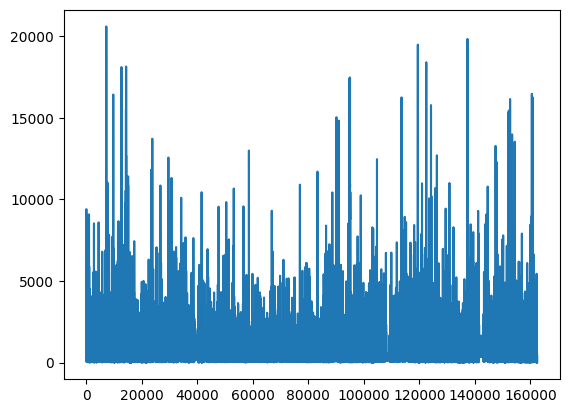

In [ ]:
# Plotting word lenghts of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [ ]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

In [ ]:
# Types of products
df['product'].value_counts()

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64

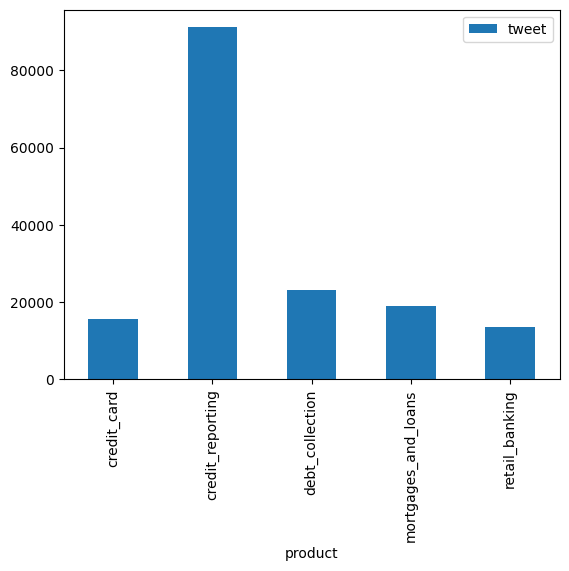

In [ ]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

Dataframe is <b>imbalanced</b>. Improving the balance of the dataframe can improve <b>accuracy</b>.

# 2. Splitting the dataset into train and test

In [ ]:
train_data, test_data = train_test_split(df, test_size = 0.20)

In [ ]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

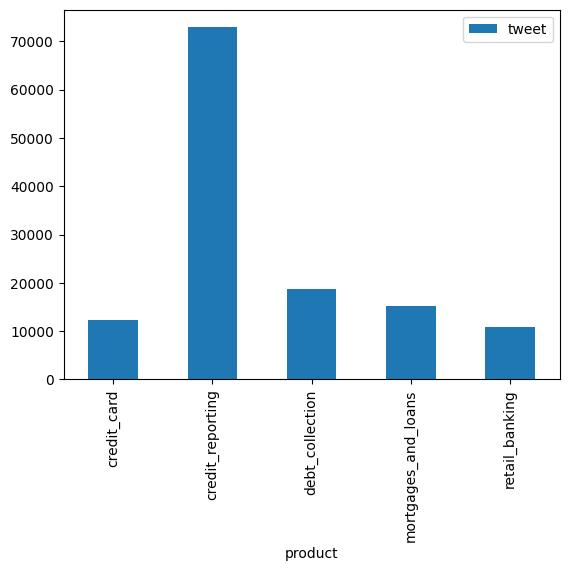

In [ ]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

* credit_card, debt_collection, mortgages_and_loans, retail_banking columns consist of <b>very few values</b>. So, the values in these columns will be increased using <b>random oversampling</b>.
* Oversampling is done in train set because this will prevent <b>data leakage</b> to test set.  

# 3. Balancing the Data Using Random Oversampling

In [ ]:
# Train set value counts
train_data.groupby('product').count()

,tweet
product,
credit_card,12392
credit_reporting,72909
debt_collection,18625
mortgages_and_loans,15192
retail_banking,10810


In [ ]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False)
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)


to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [ ]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate

,product,tweet
155860,mortgages_and_loans,informed approved forbearance period starting ...
137841,debt_collection,debt collector answering question ask verify c...
34071,credit_card,writing regard wal mart credit card account wa...
93680,credit_card,lost income due coronavirus pandemic calling c...
25337,debt_collection,copy email got ace express trying impersonate ...
...,...,...
51399,mortgages_and_loans,contacting shellpoint assistance processing sh...
159677,debt_collection,mail nothing term debt debt amount truck work ...
31326,mortgages_and_loans,middle loan modification still reviewing appli...
22563,debt_collection,good morning pandemic listen shocked reviewed ...


In [ ]:
# Concatenating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

product
credit_reporting       72909
debt_collection        25625
mortgages_and_loans    22192
credit_card            19392
retail_banking         17810
Name: count, dtype: int64

# 4. Text Preprocessing

In [ ]:
def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))

  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1

In [ ]:
# Preprocessing training and test data
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Verifying text preprocessing
train_data['tweet'].head()

140441    second time identity compromised dont understa...
155860    informed approved forbearance period starting ...
81377     process buying summer fun looking one liked sa...
26286     hi name writing complain lack response reporti...
17409     equifax reporting incorrectly day late partial...
Name: tweet, dtype: object

# 5. Label Encoding

In [ ]:
# Declaring train labels
train_labels = train_data['product']
test_labels = test_data['product']

In [ ]:
le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19392, 72909, 25625, 22192, 17810]))
(array([0, 1, 2, 3, 4]), array([ 3174, 18263,  4523,  3798,  2725]))


In [ ]:
train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

# 6. Tokenization

In [ ]:
tokenizer = Tokenizer(num_words = max_words)  # Selects most frequent words
tokenizer.fit_on_texts(train_data.tweet)      # Develops internal vocab based on training text
train_sequences = tokenizer.texts_to_sequences(train_data.tweet)  # converts text to sequence

test_sequences = tokenizer.texts_to_sequences(test_data.tweet)

In [ ]:
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((157928, 170), (32483, 170))

# 7. Bi-LSTM Model

In [ ]:
# Model Training
model = Sequential()
model.add(Embedding(max_words,
                   embedding_dim,
                   input_length=max_sequence_length))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))

model.add(GlobalMaxPool1D())

model.add(Dense(5,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 170, 32)           80000     
                                                                 
 bidirectional (Bidirection  (None, 170, 32)           6272      
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 86437 (337.64 KB)
Trainable params: 86437 (337.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## # 7.2 Passing the data through the network

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])

In [ ]:
# declaring weights of product categories
class_weight = {0: 4,
                1: 5,
                2: 3,
                3: 3,
                4: 4}

# training and validating model
history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels))

Epoch 1/20
3291/3291 [==============================] - 404s 122ms/step - loss: 0.9311 - accuracy: 0.7405 - val_loss: 0.1622 - val_accuracy: 0.8491
Epoch 2/20
3291/3291 [==============================] - 394s 120ms/step - loss: 0.6033 - accuracy: 0.8492 - val_loss: 0.1477 - val_accuracy: 0.8618
Epoch 3/20
3291/3291 [==============================] - 394s 120ms/step - loss: 0.5672 - accuracy: 0.8568 - val_loss: 0.1385 - val_accuracy: 0.8720
Epoch 4/20
3291/3291 [==============================] - 401s 122ms/step - loss: 0.5483 - accuracy: 0.8617 - val_loss: 0.1369 - val_accuracy: 0.8726
Epoch 5/20
3291/3291 [==============================] - 396s 120ms/step - loss: 0.5359 - accuracy: 0.8644 - val_loss: 0.1347 - val_accuracy: 0.8734
Epoch 6/20
3291/3291 [==============================] - 399s 121ms/step - loss: 0.5267 - accuracy: 0.8665 - val_loss: 0.1332 - val_accuracy: 0.8750
Epoch 7/20
3291/3291 [==============================] - 399s 121ms/step - loss: 0.5212 - accuracy: 0.8674 - val_

In [ ]:
# Prediction on Test Data
predicted_bi_lstm = model.predict(test_data)
predicted_bi_lstm

1016/1016 [==============================] - 25s 24ms/step


array([[1.57570557e-05, 9.99877453e-01, 9.77843883e-05, 8.01594524e-06,
        1.03953630e-06],
       [9.98278737e-01, 5.07435689e-05, 2.83554291e-05, 6.45188411e-05,
        1.57773052e-03],
       [2.47417396e-04, 1.07007675e-01, 3.31529562e-04, 8.92400622e-01,
        1.27767280e-05],
       ...,
       [2.83466798e-05, 9.99833107e-01, 2.40977915e-05, 1.04373394e-04,
        9.99234817e-06],
       [9.79283035e-01, 1.80642456e-02, 6.13201642e-04, 1.66959522e-04,
        1.87248667e-03],
       [2.35492853e-03, 9.88841593e-01, 7.74721103e-03, 9.10024857e-04,
        1.46323000e-04]], dtype=float32)

# 8. Bi LSTM Model Evaluation

## #8.1Model perfromance

In [ ]:
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.77858002 0.92771216 0.81839791 0.86786704 0.86336996]
recall: [0.81537492 0.92898209 0.76122043 0.82490785 0.86495413]
fscore: [0.79655279 0.92834669 0.78877434 0.84584233 0.86416132]
support: [ 3174 18263  4523  3798  2725]
################################
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3174
           1       0.93      0.93      0.93     18263
           2       0.82      0.76      0.79      4523
           3       0.87      0.82      0.85      3798
           4       0.86      0.86      0.86      2725

   micro avg       0.89      0.88      0.88     32483
   macro avg       0.85      0.84      0.84     32483
weighted avg       0.89      0.88      0.88     32483
 samples avg       0.88      0.88      0.88     32483



## #8.2 Model Performance with Epochs


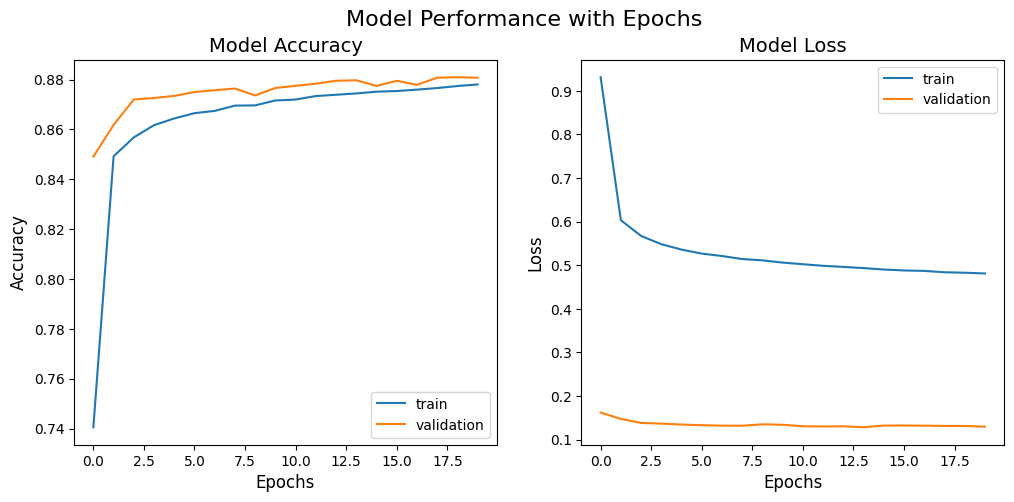

In [ ]:
def accuracy_plot(history):

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')

    # Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')


accuracy_plot(history)

## #8.3 Confusion Matrix

1016/1016 [==============================] - 26s 26ms/step


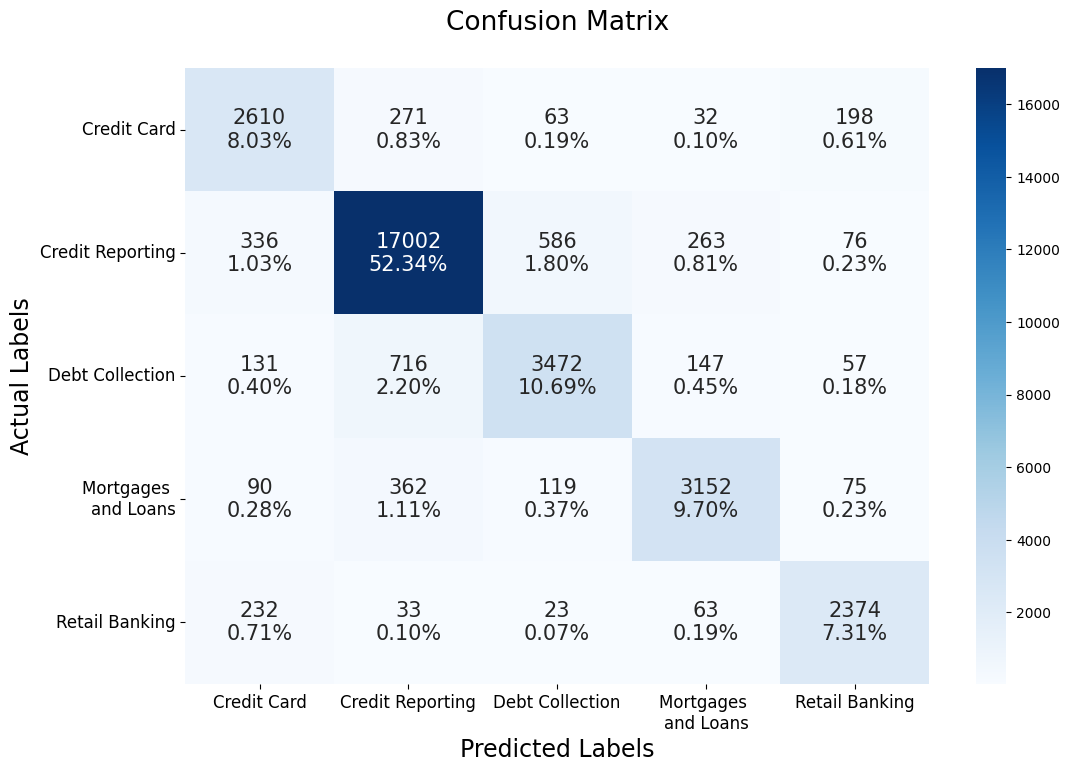

In [ ]:
def plot_cm(model, test_data, test_labels):

    products = ['Credit Card', 'Credit Reporting', 'Debt Collection', 'Mortgages \nand Loans', 'Retail Banking']

    # Calculate predictions
    pred = model.predict(test_data)

    # Declaring confusion matrix
    cm = confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(pred, axis=1))

    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    # Plotting confusion matrix
    plt.figure(figsize=(12,8))

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)

plot_cm(model, test_data, test_labels)

# 9. DistilBERT Model (From Hugging Face)

In [ ]:
!pip install -U sentence-transformers

In [ ]:
df['label'] = df['product'].factorize()[0]

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device='cpu')

sentences = list(df['tweet'])

# Example of processing in batches:
def batch_encode(model, sentences, batch_size=32):
    sentence_embeddings = []
    for i in range(0, samples, batch_size):
        batch = sentences[i:i + batch_size]
        embeddings = model.encode(batch)
        sentence_embeddings.extend(embeddings)
    return sentence_embeddings

sentence_embeddings = batch_encode(model, sentences)

In [ ]:
sentence_embeddings_array = np.vstack(sentence_embeddings)
sentence_embeddings = sentence_embeddings_array
sentence_embeddings.shape
print(sentence_embeddings.shape)
print(type(sentence_embeddings[0]))

(20000, 768)
<class 'numpy.ndarray'>


In [ ]:
sentence_embeddings_df = pd.DataFrame(sentence_embeddings)

In [ ]:
df_subset = df.iloc[:20000]
print(df_subset.shape)

(20000, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings_df, df_subset[['label']], test_size=0.2, random_state=123)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(16000, 768) (4000, 768)
(16000, 1) (4000, 1)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a Logistic Regression pipeline
logreg = Pipeline([
    ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=10000)),
])

# Fit the model on the training data
logreg.fit(X_train, y_train.values.ravel())
# Predict the test dataset
y_pred = logreg.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%')
print(classification_report(y_test, y_pred))


Accuracy: 79.00%
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       439
           1       0.65      0.66      0.66       269
           2       0.87      0.89      0.88      2236
           3       0.73      0.73      0.73       422
           4       0.72      0.65      0.68       634

    accuracy                           0.79      4000
   macro avg       0.72      0.71      0.72      4000
weighted avg       0.79      0.79      0.79      4000



##